# **BMI Prediction From Human Photograph**
---




In [3]:
!pip install ninja --user
!pip install livelossplot --user

!git clone https://github.com/PeikeLi/Self-Correction-Human-Parsing
%cd C:\Users\ayush\OneDrive\Documents\BMI-prediction-from-Human-Photograph-main\BMI-prediction-from-Human-Photograph-main\Self-Correction-Human-Parsing
  
!mkdir checkpoints
!mkdir inputs
!mkdir outputs
%cd C:\Users\ayush\OneDrive\Documents\BMI-prediction-from-Human-Photograph-main\BMI-prediction-from-Human-Photograph-main



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\ayush\OneDrive\Documents\BMI-prediction-from-Human-Photograph-main\BMI-prediction-from-Human-Photograph-main\Self-Correction-Human-Parsing


fatal: destination path 'Self-Correction-Human-Parsing' already exists and is not an empty directory.
A subdirectory or file checkpoints already exists.
A subdirectory or file inputs already exists.
A subdirectory or file outputs already exists.

C:\Users\ayush\OneDrive\Documents\BMI-prediction-from-Human-Photograph-main\BMI-prediction-from-Human-Photograph-main


In [3]:
%pip install opencv-python --user
%pip install gdown --user
%pip install numpy --user
%pip install pandas --user
%pip install livelossplot --user
%pip install scikit-learn --user
%pip install keras --user
%pip install matplotlib --user





[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


^C
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:

import cv2
import time
import gdown
import numpy
import pandas

from pathlib import Path
from keras import backend as K
from livelossplot import PlotLossesKeras
from sklearn.model_selection import KFold

import keras
from keras import layers
from keras.models import Sequential
from keras.preprocessing import image

import matplotlib.pyplot as plt
%matplotlib inline

input_shape = (224, 224, 3)

## 1.Gathering Data

Datasets contains total of 2,272 images but consider as outlier 444 images so there is 1,828 images available for training and testing.

Sources:
*   Half of the data collectd from *The Photographic Height-Weight Chart* (www.height-weight-chart.com/heightweight.html) via python script.
*   Other half is celebrity body image download via python sctipt by recognites celebrity's name from their face which get from a paper "*Show me your face and I will tell you your height, weight and body mass index*" (https://hal.inria.fr/hal-01799574/document) and use their name to download their body image from Google Images.
*   A small data from *Face-to-height-weight-BMI-estimation* by abhaymise. (https://github.com/abhaymise/Face-to-height-weight-BMI-estimation-)

A data we have got is measured in Imperial system so we use:
\begin{equation}
BMI = \frac{Pound * 703}{(Foot * 12 + Inch)^2}
\end{equation}
To produce a BMI of each images.

C:\Users\ayush\OneDrive\Documents\BMI-prediction-from-Human-Photograph-main\BMI-prediction-from-Human-Photograph-main
Total number of records: 2272
Mean BMI: 26.58938050842102
Standard Deviation of BMI: 6.666706916267456


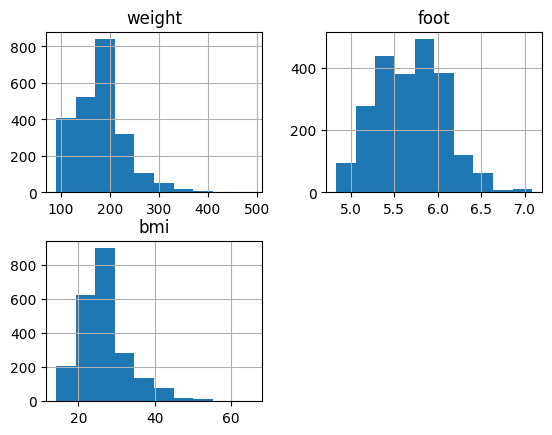

In [5]:


%cd C:\Users\ayush\OneDrive\Documents\BMI-prediction-from-Human-Photograph-main\BMI-prediction-from-Human-Photograph-main
import pandas as pd

# Read the datasets
hwcd_df = pd.read_csv("height-weight-chart_dataset.csv")
celeb_df = pd.read_csv("celeb_datasets.csv")

# Combine the two DataFrames
df = pd.concat([hwcd_df, celeb_df], ignore_index=True)

# Calculate BMI
bmi = df["weight"] * 703 / ((df["foot"] * 12) + df["inch"]) ** 2

# Calculate height in feet
foot = df["foot"] + df["inch"] / 12

# Create a new DataFrame with relevant columns
df_display = df.drop(columns=["foot", "inch"])
df_display = df_display.assign(foot=foot, bmi=bmi)

# Plot histograms
df_display.hist()

# Display summary statistics
print(f"Total number of records: {len(df.index)}")
print(f"Mean BMI: {bmi.mean()}")
print(f"Standard Deviation of BMI: {bmi.std()}")

# Assign the 'bmi' column to the original DataFrame 'df'
df = df.assign(bmi=bmi)




## 2.Preparing the data

We are preparing the data by using *Self Correction for Human Parsing* (https://github.com/PeikeLi/Self-Correction-Human-Parsing) by only extract a human body from raw dataset which the result of this model has shown below.
<table>
  <tr>
    <td>
      Original Image:<br>
      <img src="https://drive.google.com/uc?export=view&id=11oqtX5cPf5xCU2IvYBLVFs5sqnMlfm5T" width="200">
    </td>
    <td>
      Preprocessed Image using a model:<br>
      <img src="https://drive.google.com/uc?export=view&id=1ydyIAvFcoIlAxyUago_ZkJuyfSXjEooC" width="200">
    </td>
  </tr>
</table>

And we use a preprocessed image as a filter to get rid of the background by convert all of its colors pixel to 1 and multiply them to original image.

<table>
  <tr>
    <td>
      Filter Image:<br>
      <img src="https://drive.google.com/uc?export=view&id=18rjY14s3a_i9tYWXGR-FOLu0PJ2LpkvG" width="200">
    </td>
    <td>
      Labeled Image:<br>
      <img src="https://drive.google.com/uc?export=view&id=1Bqf6gtkBdL8xhsP8hEXcMDeHMVyiu_k4" width="200" height="273">
    </td>
  </tr>
</table>

Then we resize a labeled image to 244 x 244 x 3 to suit the Resnet152 recommend input tensor.


In [6]:
import keras.utils as image

# def rgb2gray(rgb):
#     return numpy.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

def preprocess_df(x, y):
  x = x.reset_index()
  X = []
  Y = []
  for i in range(x.shape[0]):

    image_filename = Path(x['image_filename'][i]).stem

    raw_filepath = 'raw_datasets/' + image_filename + ".jpg"
    preprocessed_filepath = 'raw_datasets_preprocessed/' + image_filename + ".png"
    if not Path(raw_filepath).is_file():
      raw_filepath = 'celeb_datasets/' + image_filename + ".jpg"
      preprocessed_filepath = 'celeb_datasets_preprocessed/' + image_filename + ".png"

    if Path(raw_filepath).is_file() and Path(preprocessed_filepath).is_file():
      raw_img = image.load_img(raw_filepath, target_size=(600, 400))
      raw_img = image.img_to_array(raw_img)
      preprocessed_img = image.load_img(preprocessed_filepath, target_size=(600, 400))
      preprocessed_img = image.img_to_array(preprocessed_img)

      preprocessed_img[preprocessed_img[:,:,0] > 0] = 1
      preprocessed_img[preprocessed_img[:,:,1] > 0] = 1
      preprocessed_img[preprocessed_img[:,:,2] > 0] = 1
      # img[numpy.all(img == (128, 128, 128), axis=-1)] = (0, 0, 128) # replace gray with blue
      # img[numpy.all(img == (0, 64, 0), axis=-1)] = (0, 0, 0) # replace green with black
      # img[numpy.all(img == (128, 0, 128), axis=-1)] = (0, 128, 128) # replace purple with cyan
      # img = rgb2gray(img).reshape(input_shape)

      # plt.imshow((raw_img * preprocessed_img).astype(int))
      # break

      X.append(cv2.resize(raw_img * preprocessed_img, (input_shape[0], input_shape[1])))
      Y.append(y.iloc[i])

  X = numpy.array(X)
  Y = numpy.array(Y)

  return [X, Y]


start = time.perf_counter()
X, Y = preprocess_df(df, bmi)
end = time.perf_counter()

print(f"{end - start:.2f} seconds process time")


59.14 seconds process time


### Data Normalization and Augmentation

We use ImageDataGenerator to normalize a labeled and to be augmented by rotating, shifting and horizontal flipling.

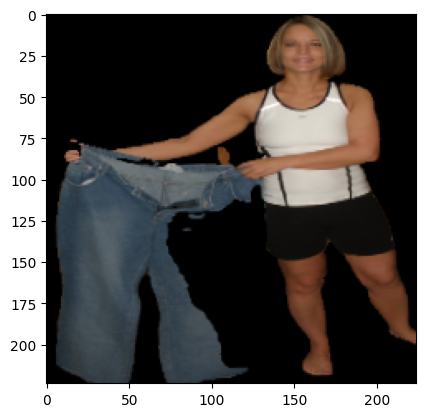

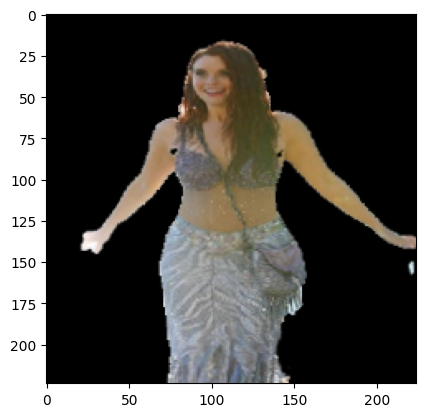

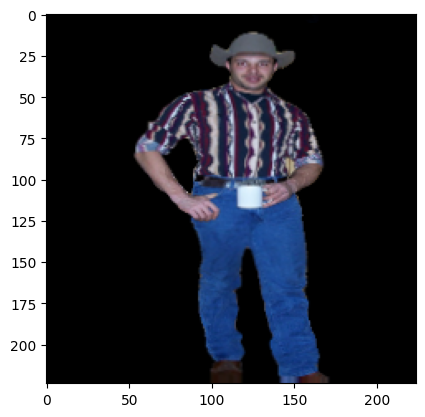

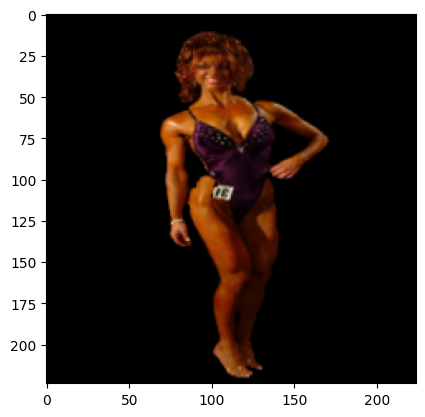

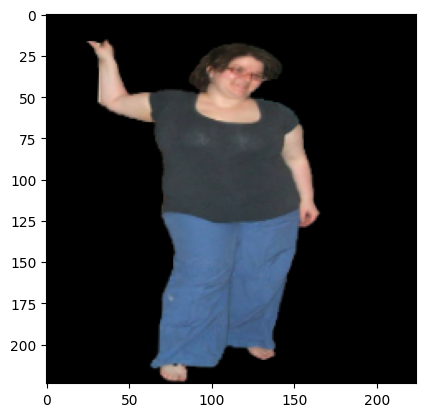

In [7]:
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt
train_datagen = image.ImageDataGenerator(
  samplewise_center=True,
  rotation_range=2,
  width_shift_range=0.02,
  # height_shift_range=0.02,
  # shear_range=0.02,
  # zoom_range=0.02,
  horizontal_flip=True
)
j = 0
for batch in train_datagen.flow(X, batch_size=5):
  for b in batch:
    plt.figure(j)
    plt.imshow(image.array_to_img(b))
    j += 1
  break

test_datagen = image.ImageDataGenerator(
  samplewise_center=True,
)

## 3.Choosing a model

* From the experiments, we decide to use ResNet152 for the best results.
* We use pre-trained weight called "imagenet" to initialize a model.
* By using it, we mean that we use it for extract a feature of human from an image so we freeze an entire model and feed an output to Fully-Connected Layer.
* A Fully-Connected Layer contains 256 neurons and using ReLu function as activation function.
* We use dropout layer with probability 0.25
* An output layer consist of only one neuron which uses linear activation function.


<img src="https://drive.google.com/uc?export=view&id=1u20brFPULhqItLZCa1zrmiHkaNKtqvMX" width="450">

In [8]:
base_model = keras.applications.ResNet152(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling="avg"
)

base_model.trainable = False
base_model.summary()

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                      

### Extract Features

* We use k-fold cross validation to train a model by we choose k=5 and in the meanwhile, we do a features extraction before initialize our own model.
* We keep all 5 fold in the list called train_features, train_labels, test_features and test_labels for not to repeated it.

In [9]:

batch_size=32
def extract_features(x, y, sample_count, datagen):
    features = numpy.zeros(shape=(sample_count, 2048))
    labels = numpy.zeros(shape=(sample_count))
    generator = datagen.flow(
        x, y,
        batch_size=batch_size
    )
    total = 0
    left_index = 0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        gap = features_batch.shape[0]
        total += gap
        gap_diff = total - sample_count
        gap_diff = gap_diff if gap_diff > 0 else 0
        features[left_index : left_index + (gap-gap_diff)] = features_batch[0:gap-gap_diff]
        labels[left_index : left_index + (gap-gap_diff)] = labels_batch[0:gap-gap_diff]
        left_index += gap
        if total >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features = [None]*5
train_labels = [None]*5
test_features = [None]*5
test_labels = [None]*5

k = 0
kf = KFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(X):
  X_train, Y_train, X_test, Y_test = X[train_index], Y[train_index], X[test_index], Y[test_index]

  print(f"Extract features from fold number {k+1}")
  start = time.perf_counter()
  train_features[k], train_labels[k] = extract_features(X_train, Y_train, 2000, datagen=train_datagen)
  test_features[k], test_labels[k] = extract_features(X_test, Y_test, 2000, datagen=test_datagen)
  end = time.perf_counter()
  print(f"Finished with {end - start:.2f} seconds process time")
  k += 1

Extract features from fold number 1
1/1 [==============================] - 7s 7s/step
Finished with 809.62 seconds process time
Extract features from fold number 2
1/1 [==============================] - 6s 6s/step
Finished with 822.89 seconds process time
Extract features from fold number 3
1/1 [==============================] - 6s 6s/step
Finished with 806.32 seconds process time
Extract features from fold number 4
1/1 [==============================] - 6s 6s/step
Finished with 790.74 seconds process time
Extract features from fold number 5
1/1 [==============================] - 5s 5s/step
Finished with 761.36 seconds process time


## 4.Training
* Optimizer: The stochastic gradient descent (SGD) algorithm.
* Learning Rate: Start from 1e-5 and then we use the learning rate decay policy, which is implemented as follows:
\begin{equation}
LR = LR_{Base} (1 + \gamma * epoch)^{-power}
\end{equation}
where γ is 0.001 and power is 0.75. We use a momentum of 0.9
* Loss function: Huber function
* Metrics: Huber, Mean Absolute Error and R Squared

In [10]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def lr_scheduler(epoch, lr):
   return 1e-5 * (1 + 0.001 * epoch) ** (-0.75)

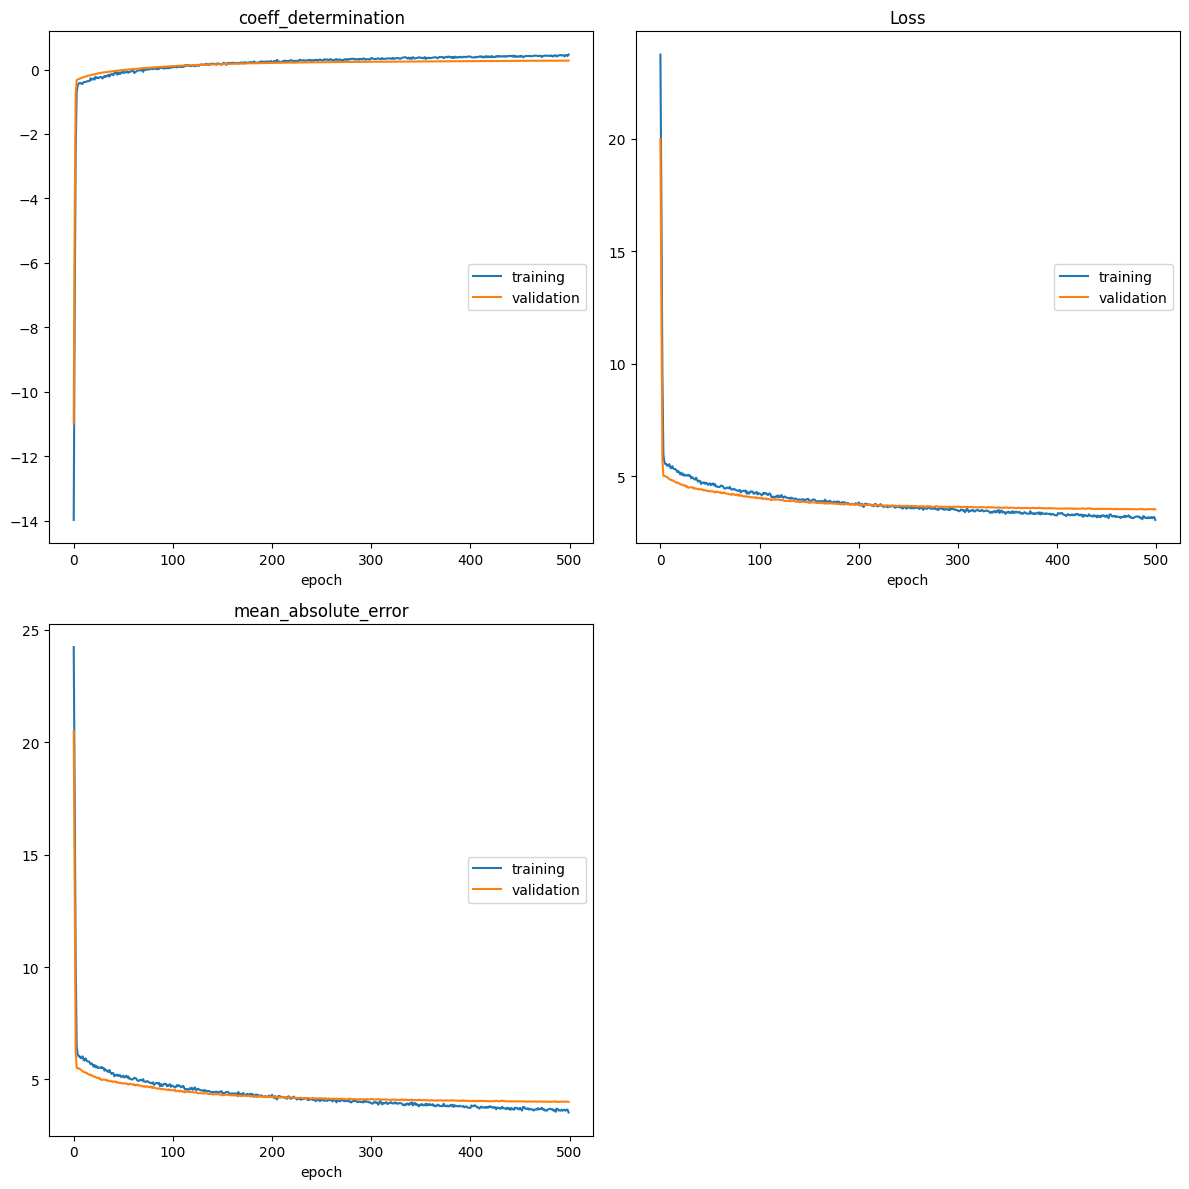

coeff_determination
	training         	 (min:  -13.976, max:    0.463, cur:    0.463)
	validation       	 (min:  -10.984, max:    0.276, cur:    0.276)
Loss
	training         	 (min:    3.070, max:   23.728, cur:    3.070)
	validation       	 (min:    3.534, max:   19.987, cur:    3.539)
mean_absolute_error
	training         	 (min:    3.534, max:   24.228, cur:    3.534)
	validation       	 (min:    4.000, max:   20.487, cur:    4.004)
63/63 - 1s - loss: 3.0703 - mean_absolute_error: 3.5337 - coeff_determination: 0.4632 - val_loss: 3.5388 - val_mean_absolute_error: 4.0037 - val_coeff_determination: 0.2761 - lr: 7.3816e-06 - 861ms/epoch - 14ms/step
63/63 [==============================] - 0s 2ms/step - loss: 3.5388 - mean_absolute_error: 4.0037 - coeff_determination: 0.2761


In [11]:




VALIDAITON_LOSS = []

for j in range(5):
  model = Sequential()
  model.add(layers.Dense(256, activation='relu', input_dim=2048))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(1, activation='linear'))

  model.compile(optimizer=keras.optimizers.SGD(
      learning_rate=1e-5,
      momentum=0.9
  ), loss=keras.losses.Huber(), metrics=["mean_absolute_error", coeff_determination])

  history = model.fit(train_features[j], train_labels[j], epochs=500,
    validation_data=(test_features[j], test_labels[j]),
    verbose=2,
    callbacks=[
          PlotLossesKeras(),
          keras.callbacks.LearningRateScheduler(lr_scheduler),
    ]
  )
  model.save(f"last_model{j}.h5")

  results = model.evaluate(test_features[j], test_labels[j])
  VALIDAITON_LOSS.append(results)

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# axes = plt.gca()
# axes.set_xlim([0, 25])
# plt.show()

# history = model.fit(train_datagen.flow(x_train, y_train, batch_size=16),
#                     epochs=1000,
#                     validation_data=test_datagen.flow(x_test, y_test, batch_size=32),
#                     verbose=2,
#                     callbacks=[
#                           PlotLossesKeras(),
#                           keras.callbacks.LearningRateScheduler(lr_scheduler),
#                           # keras.callbacks.EarlyStopping(
#                           #     monitor='val_loss',
#                           #     patience=5,
#                           #     restore_best_weights=True
#                           # )
#                     ]
# )



## 5.Evaluvate

[Huber loss, MAE, R Squared] of all 5-folds

In [12]:
VALIDAITON_LOSS


[[3.7441821098327637, 4.214625358581543, 0.2790124714374542],
 [3.89937686920166, 4.369856357574463, 0.2975354790687561],
 [3.694927453994751, 4.166842937469482, 0.24081245064735413],
 [3.7366888523101807, 4.204925060272217, 0.35796576738357544],
 [3.5387821197509766, 4.003676414489746, 0.2760777175426483]]

## 6.Test with your photo!

We have selected the best model which MAE is equal to 4.053

In [13]:

%cd Self-Correction-Human-Parsing
atr_dataset_url = 'https://drive.google.com/uc?id=1ruJg4lqR_jgQPj-9K0PP-L2vJERYOxLP'
gdown.download(atr_dataset_url, 'checkpoints/atr.pth', quiet=False)

C:\Users\ayush\OneDrive\Documents\BMI-prediction-from-Human-Photograph-main\BMI-prediction-from-Human-Photograph-main\Self-Correction-Human-Parsing


Downloading...
From (uriginal): https://drive.google.com/uc?id=1ruJg4lqR_jgQPj-9K0PP-L2vJERYOxLP
From (redirected): https://drive.google.com/uc?id=1ruJg4lqR_jgQPj-9K0PP-L2vJERYOxLP&confirm=t&uuid=b5c09ad6-ab89-4a84-83a6-4c60dabde17a
To: C:\Users\ayush\OneDrive\Documents\BMI-prediction-from-Human-Photograph-main\BMI-prediction-from-Human-Photograph-main\Self-Correction-Human-Parsing\checkpoints\atr.pth
100%|██████████| 267M/267M [04:58<00:00, 895kB/s]  


'checkpoints/atr.pth'

In [3]:
%pip install ipython --user


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
%pip install torch --user

Note: you may need to restart the kernel to use updated packages.Collecting torch
     ---------------------------------------- 0.0/172.3 MB ? eta -:--:--
     -------------------------------------- 0.0/172.3 MB 653.6 kB/s eta 0:04:24
     ---------------------------------------- 0.1/172.3 MB 1.7 MB/s eta 0:01:41
     ---------------------------------------- 0.3/172.3 MB 2.1 MB/s eta 0:01:21
     ---------------------------------------- 0.7/172.3 MB 3.4 MB/s eta 0:00:51
     ---------------------------------------- 1.4/172.3 MB 5.8 MB/s eta 0:00:30
     ---------------------------------------- 1.8/172.3 MB 6.3 MB/s eta 0:00:28
      --------------------------------------- 2.6/172.3 MB 8.0 MB/s eta 0:00:22
      --------------------------------------- 2.7/172.3 MB 8.2 MB/s eta 0:00:21
      --------------------------------------- 2.7/172.3 MB 8.2 MB/s eta 0:00:21
      --------------------------------------- 2.7/172.3 MB 8.2 MB/s eta 0:00:21
     - --------------------------------------


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Traceback (most recent call last):
  File "simple_extractor.py", line 15, in <module>
    import torch
ModuleNotFoundError: No module named 'torch'


C:\Users\ayush\AppData\Local\Temp\ipykernel_12128\3066986492.py:33: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((500, 500), Image.ANTIALIAS)
Traceback (most recent call last):
  File "simple_extractor.py", line 15, in <module>
    import torch
ModuleNotFoundError: No module named 'torch'


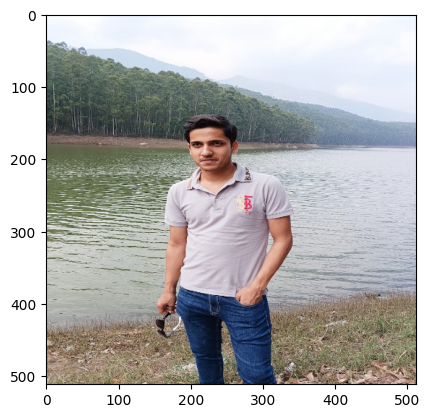

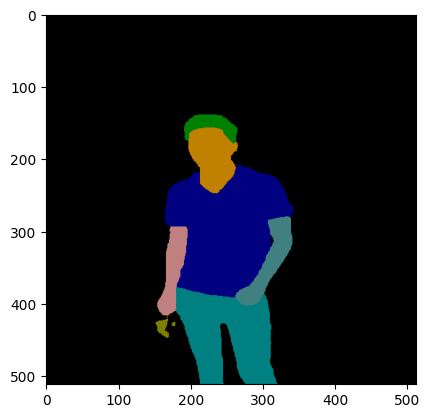

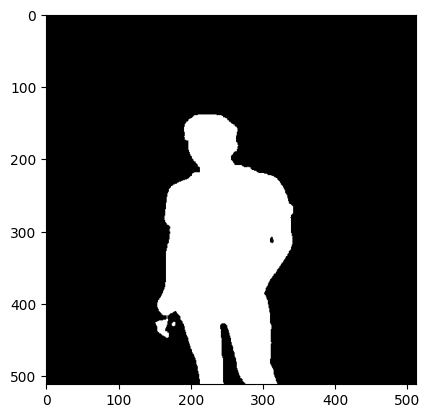

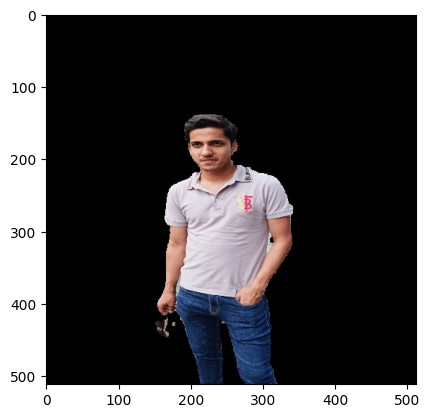

In [20]:


import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image
from pathlib import Path
import shutil

class ImageUploader:
    def __init__(self, master):
        self.master = master
        self.filepath = None
        master.title("Image Uploader")
        
        self.label = tk.Label(master, text="Upload an Image")
        self.label.pack()
        
        self.upload_button = tk.Button(master, text="Upload", command=self.upload_file)
        self.upload_button.pack()
        
        self.canvas = tk.Canvas(master, width=500, height=500)
        self.canvas.pack()
        
        self.filepath_label = tk.Label(master, text="Filepath: None")
        self.filepath_label.pack()

    def upload_file(self):
        filepath = filedialog.askopenfilename(filetypes=[("Image files", "*.png;*.jpg;*.jpeg;*.bmp;*.gif")])
        
        if filepath:
            image = Image.open(filepath)
            image = image.resize((500, 500), Image.ANTIALIAS)
            self.photo = ImageTk.PhotoImage(image)
            
            self.canvas.create_image(250, 250, anchor=tk.CENTER, image=self.photo)
            self.filepath_label.config(text=f"Filepath: {filepath}")
            self.filepath = filepath

def get_file_path():
    root = tk.Tk()
    app = ImageUploader(root)
    root.mainloop()
    return app.filepath

# Get the filepath using the GUI
uploaded_file_path = get_file_path()

# Copy the uploaded file to the inputs directory and setup the input_filename variable
shutil.copy(uploaded_file_path, 'inputs')
input_filename = Path(uploaded_file_path).stem
# Your existing code, with paths adjusted to use the input_filename variable
input_shape = (512, 512)  # Define your input shape here
!python3 simple_extractor.py --dataset 'atr' --model-restore 'checkpoints/atr.pth' --input-dir 'inputs' --output-dir 'outputs'
raw_input_image = cv2.imread(f"inputs/{input_filename}.jpg")
raw_input_image = cv2.cvtColor(raw_input_image, cv2.COLOR_BGR2RGB)
raw_input_image = cv2.resize(raw_input_image, (input_shape[0], input_shape[1]))
plt.figure(0)
plt.imshow(raw_input_image)

preprocessed_input_image = image.load_img(f"outputs/{input_filename}.png", target_size=input_shape)
preprocessed_input_image = image.img_to_array(preprocessed_input_image)
plt.figure(1)
plt.imshow(preprocessed_input_image.astype(int))

plt.figure(2)
preprocessed_input_image[preprocessed_input_image[:,:,0] > 0] = 1
preprocessed_input_image[preprocessed_input_image[:,:,1] > 0] = 1
preprocessed_input_image[preprocessed_input_image[:,:,2] > 0] = 1
plt.imshow(preprocessed_input_image)

plt.figure(3)
final_input_image = raw_input_image * preprocessed_input_image
plt.imshow(final_input_image.astype(int))


In [25]:
%cd C:\Users\ayush\OneDrive\Documents\BMI-prediction-from-Human-Photograph-main\BMI-prediction-from-Human-Photograph-main
test_datagen = image.ImageDataGenerator(
  samplewise_center=True,
)

generator = test_datagen.flow(
    numpy.expand_dims(final_input_image, axis=0),
    batch_size=1
)
features_batch = base_model.predict(generator)

dependencies = {
    'coeff_determination': coeff_determination
}
model = keras.models.load_model('3.935_model.h5', custom_objects=dependencies)
preds = model.predict(features_batch)
bmi_pred = preds[0][0]
print(f"BMI: {bmi_pred}")
if bmi_pred < 15:
  print("Very severely underweight")
elif 15 <= bmi_pred < 16:
  print("Severely underweight")
elif 16 <= bmi_pred < 18.5:
  print("Underweight")
elif 18.5 <= bmi_pred < 25:
  print("Normal")
elif 25 <= bmi_pred < 30:
  print("Overweight")
elif 30 <= bmi_pred < 35:
  print("Moderately obese")
elif 35 <= bmi_pred < 40:
  print("Severely obese")
elif bmi_pred >= 40:
  print("Very severely obese")



C:\Users\ayush\OneDrive\Documents\BMI-prediction-from-Human-Photograph-main\BMI-prediction-from-Human-Photograph-main
1/1 [==============================] - 0s 56ms/step
BMI: 17.637113571166992
Underweight


**References**
<p>- Self-Correction for Human Parsing (https://arxiv.org/pdf/1910.09777.pdf)</p>
<p>- Show me your face and I will tell you your height,
weight and body mass index (https://hal.inria.fr/hal-01799574/document)</p>
<p>- Estimation of Body Mass Index from
Photographs using Deep Convolutional Neural
Networks (https://arxiv.org/pdf/1908.11694v1.pdf)</p>
